# BrainTumor_MRI_Pipeline_Colab_step_by_step.py
# 1. Dataset Selection




#  Install & imports


In [1]:
from google.colab import files
import zipfile, os, glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


print('Libraries imported')

Libraries imported


# CELL 2 — Upload & extract ZIP files -->

In [3]:
uploaded = files.upload()

for filename in uploaded.keys():
    foldername = filename.split('.')[0].replace(' ', '_').lower() + "_dataset"
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(foldername)
    print(f"Extracted {filename} to {foldername}")


Saving 377 images for Brian Tumor MRI Images.zip to 377 images for Brian Tumor MRI Images.zip
Extracted 377 images for Brian Tumor MRI Images.zip to 377_images_for_brian_tumor_mri_images_dataset


## 2. Dataset & Transforms (THIS is where the grayscale transform goes)

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 16  # reduce to 8 or 4 if you hit OOM on GPU

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),   # <-- force grayscale (1 channel)
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])    # normalize for single-channel images
])


## 3. Locate training / testing folders automatically

In [5]:
# We expect folders with names like: .../Training and .../Testing inside the extracted dataset folder
dataset_folders = [d for d in os.listdir() if d.endswith('_dataset') and os.path.isdir(d)]
print('Found dataset folders:', dataset_folders)

def find_train_test(dataset_folders):
    train_dir = None
    test_dir = None
    for base in dataset_folders:
        for root, dirs, files in os.walk(base):
            for d in dirs:
                if d.lower() == 'training':
                    train_dir = os.path.join(root, d)
                elif d.lower() == 'testing':
                    test_dir = os.path.join(root, d)
    return train_dir, test_dir

train_dir, test_dir = find_train_test(dataset_folders)
if not train_dir or not test_dir:
    raise FileNotFoundError('Could not find Training and Testing directories automatically. Please check your zip structure.')

print('Train dir:', train_dir)
print('Test dir :', test_dir)

Found dataset folders: ['377_images_for_brian_tumor_mri_images_dataset']
Train dir: 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Training
Test dir : 377_images_for_brian_tumor_mri_images_dataset/377 images for Brian Tumor MRI Images/Testing


## 4. Create datasets & dataloaders

In [6]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes
print('Classes:', class_names)

Classes: ['Glioma', 'Meningioma', 'No_Tumor', 'Pituitary']


## Quick visual sanity check: show one sample per class

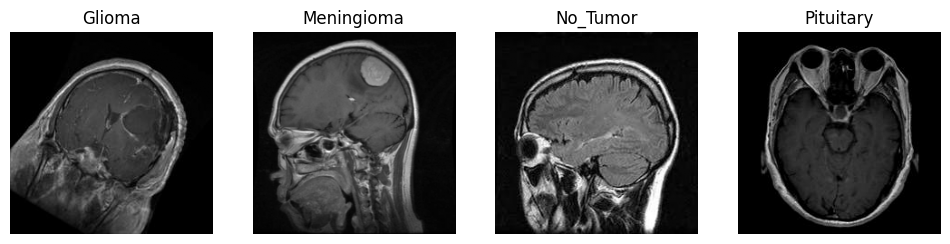

In [7]:
def imshow(img, title=''):
    # img expected to be a tensor with shape [1, H, W]
    img = img * 0.5 + 0.5  # unnormalize
    npimg = img.numpy()
    if npimg.shape[0] == 1:
        plt.imshow(np.squeeze(npimg), cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(title)
    plt.axis('off')

examples = {}
for img, label in train_dataset:
    if label not in examples:
        examples[label] = img
    if len(examples) == len(class_names):
        break

plt.figure(figsize=(12,3))
for i, (label, img) in enumerate(examples.items()):
    plt.subplot(1, len(examples), i+1)
    imshow(img, title=class_names[label])
plt.show()


# 2. Model definitions
## ==> Incepotion Block ( InceptionNet )
## ==> Residual Block (ResnNet )
## ==> DenseBlock (DensNet)
## ==> hybrid ( Residual + Inception )
## ==> Custom CNN

### ==> 1st : - Incepotion Block ( InceptionNet ) <========

In [8]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.branch1 = nn.Conv2d(in_channels, 16, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.Conv2d(16, 24, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.Conv2d(16, 24, kernel_size=5, padding=2)
        )

        self.branch4 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.branch4_conv = nn.Conv2d(in_channels, 24, kernel_size=1)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4_conv(self.branch4(x))
        return torch.cat([b1, b2, b3, b4], dim=1)  # concat along channel

class InceptionNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.inception = InceptionBlock(32)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(88, num_classes)  # 16+24+24+24 = 88

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.inception(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

### ==> 2nd : - Residual block and small ResNet <========



In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNetSmall(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.layer1 = ResidualBlock(1, 32)
        self.layer2 = ResidualBlock(32, 64)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

### ==> 3rd : -  Dense block <========



In [11]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate=16, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList()
        channels = in_channels
        for _ in range(num_layers):
            self.layers.append(nn.Conv2d(channels, growth_rate, kernel_size=3, padding=1))
            channels += growth_rate

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            out = F.relu(layer(torch.cat(features, 1)))
            features.append(out)
        return torch.cat(features, 1)

class DenseNetSmall(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.denseblock = DenseBlock(32, growth_rate=16, num_layers=3)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(32 + 16*3, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.denseblock(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

### ====> 4th :  Hybrid (Residual + Inception) <=====


In [12]:
class HybridBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.inception = InceptionBlock(in_channels)
        self.shortcut = nn.Conv2d(in_channels, 88, kernel_size=1)  # match inception channels

    def forward(self, x):
        out = self.inception(x)
        shortcut = self.shortcut(x)
        out = out + shortcut
        return F.relu(out)

class HybridNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.hybrid = HybridBlock(32)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(88, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.hybrid(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

### ===>  Simple Custom CNN <====


In [13]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool_final = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.pool_final(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# 6. Training & evaluation helpers

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)

        # validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = outputs.max(1)
                total += labels.size(0)
                correct += preds.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_acc.append(100. * correct / total)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.2f}% "
              f"Val Loss: {val_losses[-1]:.4f} Val Acc: {val_acc[-1]:.2f}%")

    return model, (train_losses, val_losses, train_acc, val_acc)


def evaluate_model(model, test_loader, class_names):
    model = model.to(device)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print('\nEvaluation Results:')
    print(f'Accuracy:  {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall:    {rec:.4f}')
    print(f'F1-score:  {f1:.4f}')

    return acc, prec, rec, f1

Using device: cpu


# Plotting helpers

In [15]:
import matplotlib

def plot_training_curves(curves, model_name):
    train_losses, val_losses, train_acc, val_acc = curves
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    plt.show()

from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_pr_curves(model, test_loader, class_names):
    model.eval()
    y_true, y_score = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_score.extend(probs)

    y_true = np.array(y_true)
    y_score = np.array(y_score)
    n_classes = len(class_names)

    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, y_score[:, i])
        plt.plot(recall, precision, label=class_names[i])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()


# 7. Create models dict and run training loop


Training InceptionNet...
Epoch [1/10] Train Loss: 1.3905 Train Acc: 28.57% Val Loss: 1.3681 Val Acc: 31.58%
Epoch [2/10] Train Loss: 1.3670 Train Acc: 31.56% Val Loss: 1.3605 Val Acc: 35.53%
Epoch [3/10] Train Loss: 1.3485 Train Acc: 29.90% Val Loss: 1.3498 Val Acc: 35.53%
Epoch [4/10] Train Loss: 1.3170 Train Acc: 37.21% Val Loss: 1.3672 Val Acc: 31.58%
Epoch [5/10] Train Loss: 1.2968 Train Acc: 37.54% Val Loss: 1.3695 Val Acc: 34.21%
Epoch [6/10] Train Loss: 1.2840 Train Acc: 39.20% Val Loss: 1.3996 Val Acc: 43.42%
Epoch [7/10] Train Loss: 1.2726 Train Acc: 39.87% Val Loss: 1.4320 Val Acc: 31.58%
Epoch [8/10] Train Loss: 1.2622 Train Acc: 39.53% Val Loss: 1.3836 Val Acc: 30.26%
Epoch [9/10] Train Loss: 1.2435 Train Acc: 39.87% Val Loss: 1.3718 Val Acc: 32.89%
Epoch [10/10] Train Loss: 1.2368 Train Acc: 43.85% Val Loss: 1.3938 Val Acc: 44.74%

Evaluation Results:
Accuracy:  0.4474
Precision: 0.3413
Recall:    0.4474
F1-score:  0.3864


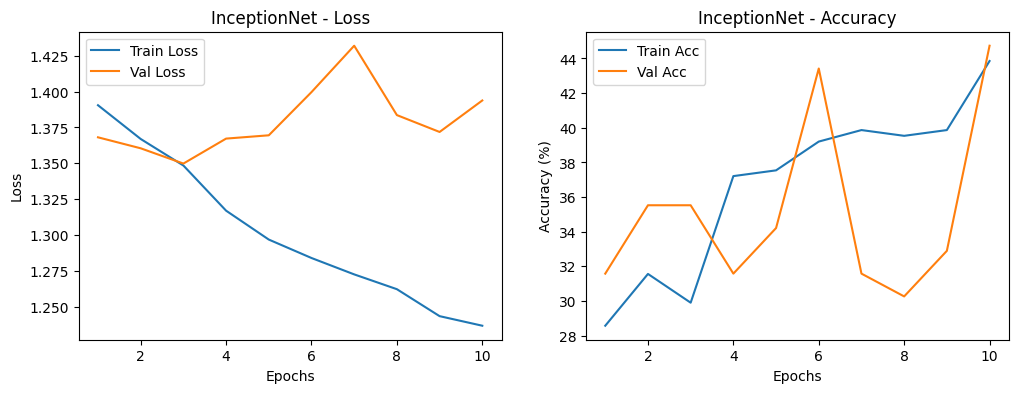

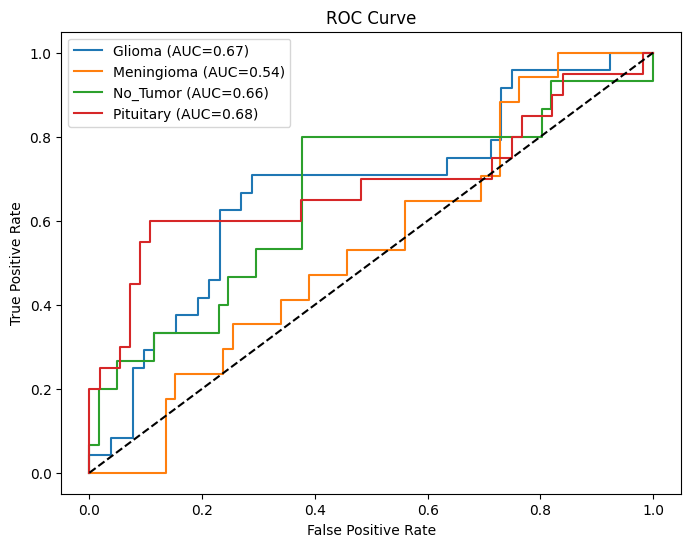

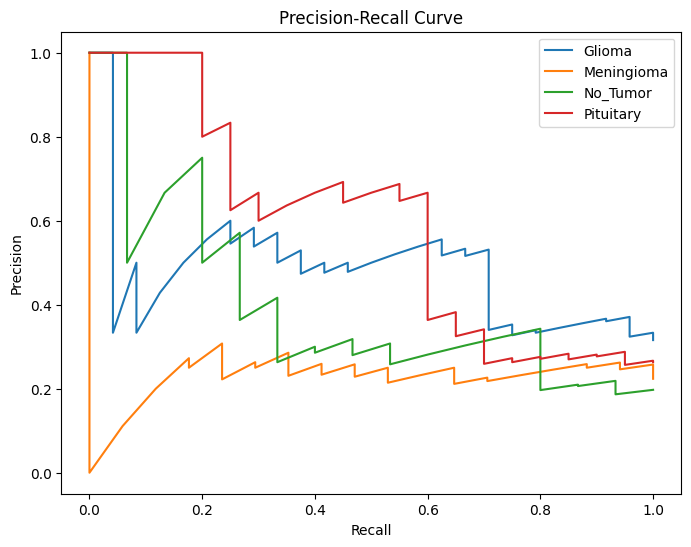


Training ResNetSmall...
Epoch [1/10] Train Loss: 1.2980 Train Acc: 38.87% Val Loss: 1.3262 Val Acc: 34.21%
Epoch [2/10] Train Loss: 1.2115 Train Acc: 47.51% Val Loss: 1.3285 Val Acc: 40.79%
Epoch [3/10] Train Loss: 1.1921 Train Acc: 45.85% Val Loss: 1.2671 Val Acc: 40.79%
Epoch [4/10] Train Loss: 1.1547 Train Acc: 50.83% Val Loss: 1.3782 Val Acc: 50.00%
Epoch [5/10] Train Loss: 1.1532 Train Acc: 52.16% Val Loss: 1.3140 Val Acc: 51.32%
Epoch [6/10] Train Loss: 1.1190 Train Acc: 54.15% Val Loss: 1.3498 Val Acc: 47.37%
Epoch [7/10] Train Loss: 1.1089 Train Acc: 52.82% Val Loss: 1.6103 Val Acc: 43.42%
Epoch [8/10] Train Loss: 1.1216 Train Acc: 54.82% Val Loss: 1.1878 Val Acc: 60.53%
Epoch [9/10] Train Loss: 1.0828 Train Acc: 60.80% Val Loss: 1.2606 Val Acc: 56.58%
Epoch [10/10] Train Loss: 1.0663 Train Acc: 54.49% Val Loss: 1.4016 Val Acc: 42.11%

Evaluation Results:
Accuracy:  0.4211
Precision: 0.4848
Recall:    0.4211
F1-score:  0.3867


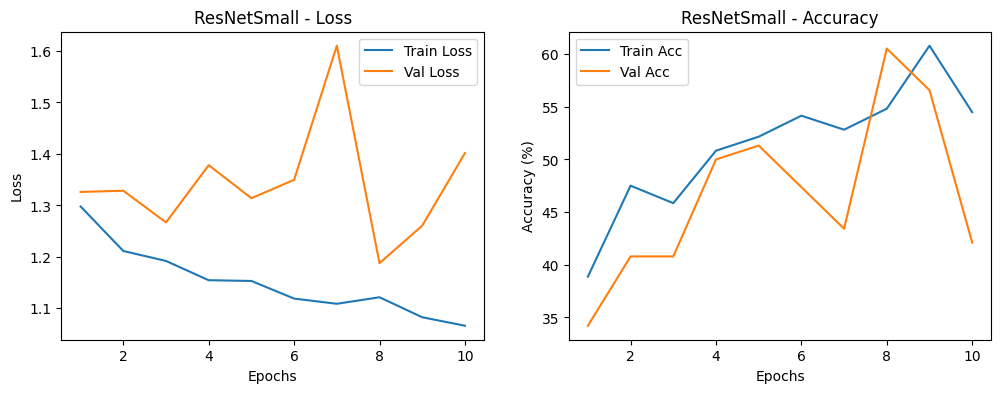

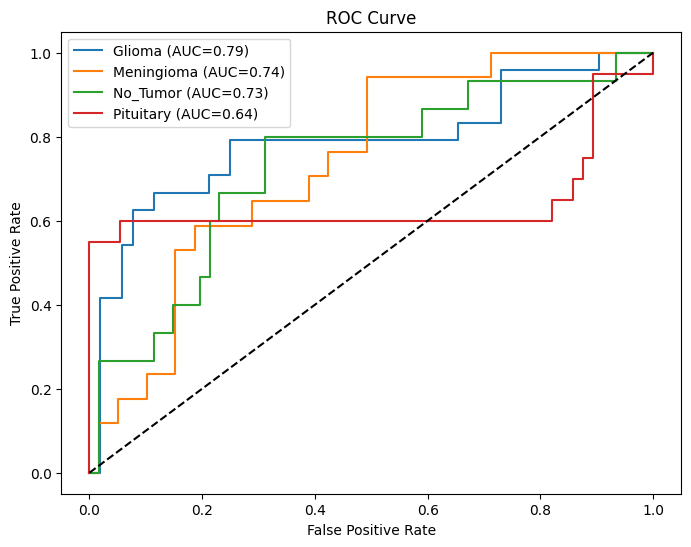

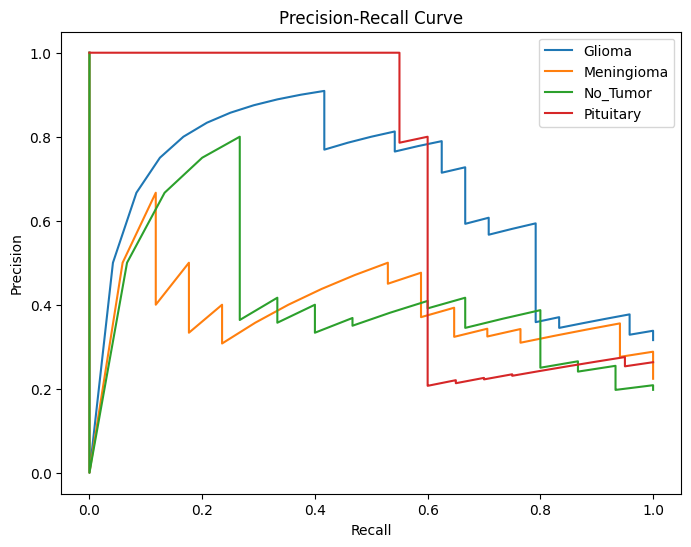


Training DenseNetSmall...
Epoch [1/10] Train Loss: 1.3753 Train Acc: 31.56% Val Loss: 1.3679 Val Acc: 31.58%
Epoch [2/10] Train Loss: 1.3506 Train Acc: 32.56% Val Loss: 1.3534 Val Acc: 35.53%
Epoch [3/10] Train Loss: 1.3162 Train Acc: 36.54% Val Loss: 1.3865 Val Acc: 31.58%
Epoch [4/10] Train Loss: 1.2790 Train Acc: 38.54% Val Loss: 1.4244 Val Acc: 31.58%
Epoch [5/10] Train Loss: 1.2751 Train Acc: 38.87% Val Loss: 1.4235 Val Acc: 31.58%
Epoch [6/10] Train Loss: 1.2622 Train Acc: 38.54% Val Loss: 1.4466 Val Acc: 32.89%
Epoch [7/10] Train Loss: 1.2613 Train Acc: 39.20% Val Loss: 1.4455 Val Acc: 30.26%
Epoch [8/10] Train Loss: 1.2542 Train Acc: 38.87% Val Loss: 1.4814 Val Acc: 40.79%
Epoch [9/10] Train Loss: 1.2474 Train Acc: 38.21% Val Loss: 1.4357 Val Acc: 28.95%
Epoch [10/10] Train Loss: 1.2755 Train Acc: 39.87% Val Loss: 1.5248 Val Acc: 38.16%

Evaluation Results:
Accuracy:  0.3816
Precision: 0.3355
Recall:    0.3816
F1-score:  0.3217


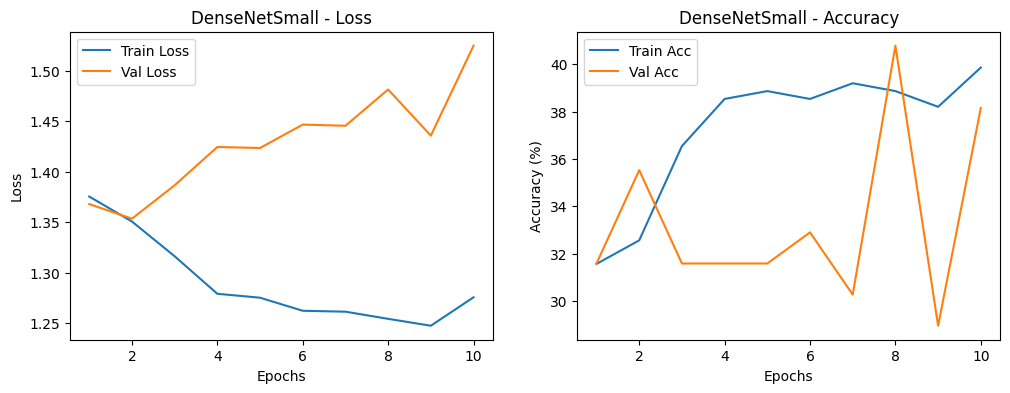

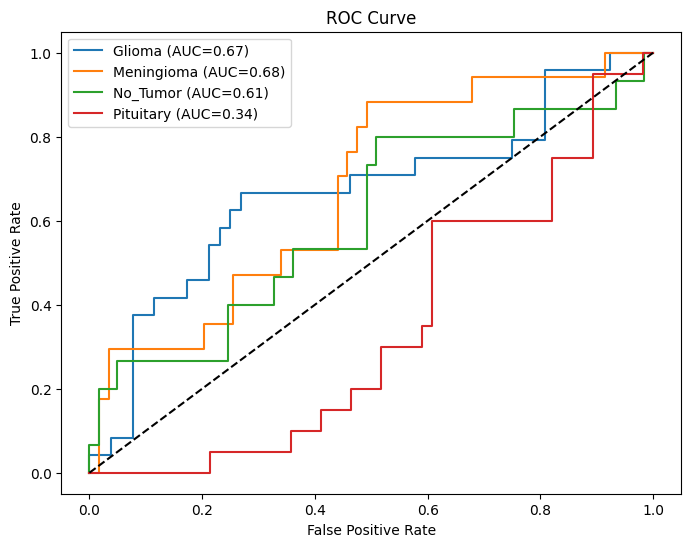

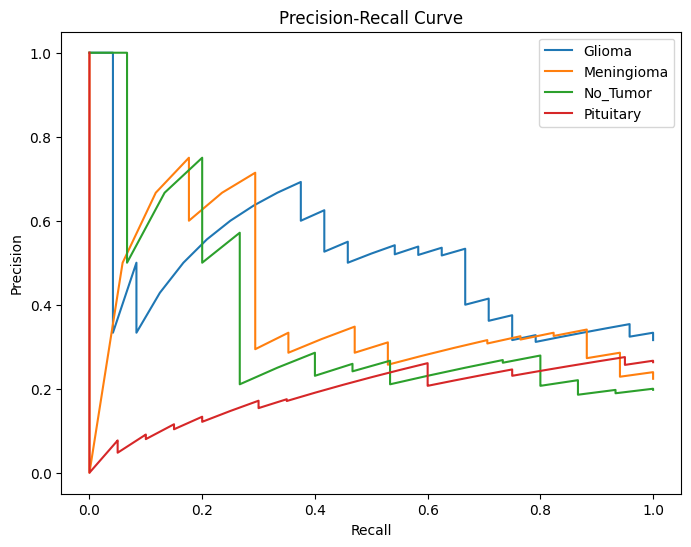


Training HybridNet...
Epoch [1/10] Train Loss: 1.3775 Train Acc: 28.24% Val Loss: 1.3607 Val Acc: 32.89%
Epoch [2/10] Train Loss: 1.3577 Train Acc: 32.56% Val Loss: 1.3498 Val Acc: 38.16%
Epoch [3/10] Train Loss: 1.3346 Train Acc: 34.88% Val Loss: 1.3432 Val Acc: 30.26%
Epoch [4/10] Train Loss: 1.3028 Train Acc: 37.87% Val Loss: 1.3569 Val Acc: 31.58%
Epoch [5/10] Train Loss: 1.2835 Train Acc: 37.54% Val Loss: 1.4121 Val Acc: 31.58%
Epoch [6/10] Train Loss: 1.2721 Train Acc: 38.87% Val Loss: 1.4007 Val Acc: 30.26%
Epoch [7/10] Train Loss: 1.2693 Train Acc: 40.20% Val Loss: 1.4015 Val Acc: 31.58%
Epoch [8/10] Train Loss: 1.2646 Train Acc: 38.21% Val Loss: 1.4032 Val Acc: 28.95%
Epoch [9/10] Train Loss: 1.2544 Train Acc: 39.20% Val Loss: 1.4310 Val Acc: 31.58%
Epoch [10/10] Train Loss: 1.2550 Train Acc: 38.87% Val Loss: 1.4145 Val Acc: 35.53%

Evaluation Results:
Accuracy:  0.3553
Precision: 0.3968
Recall:    0.3553
F1-score:  0.3044


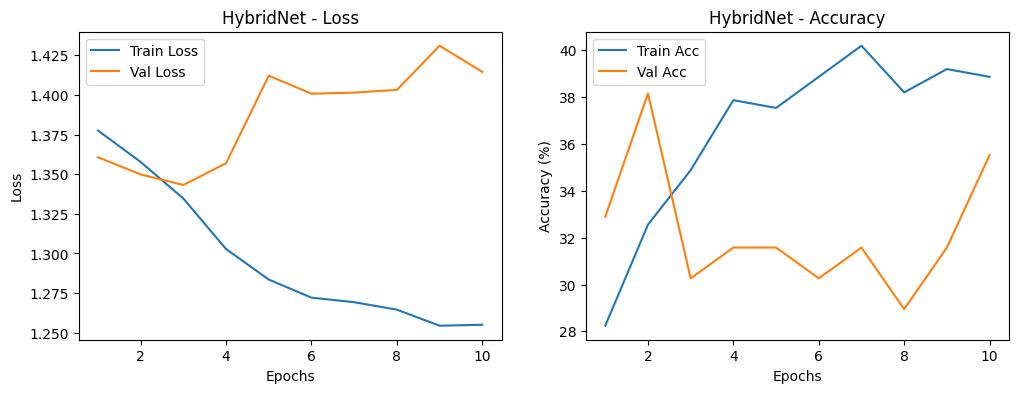

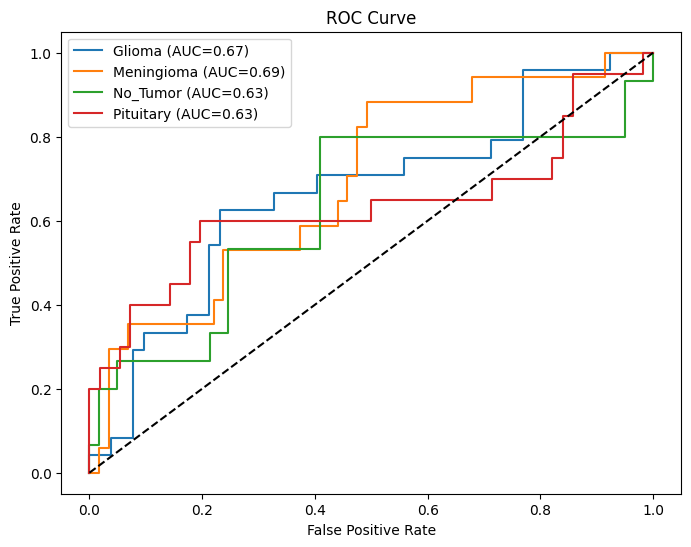

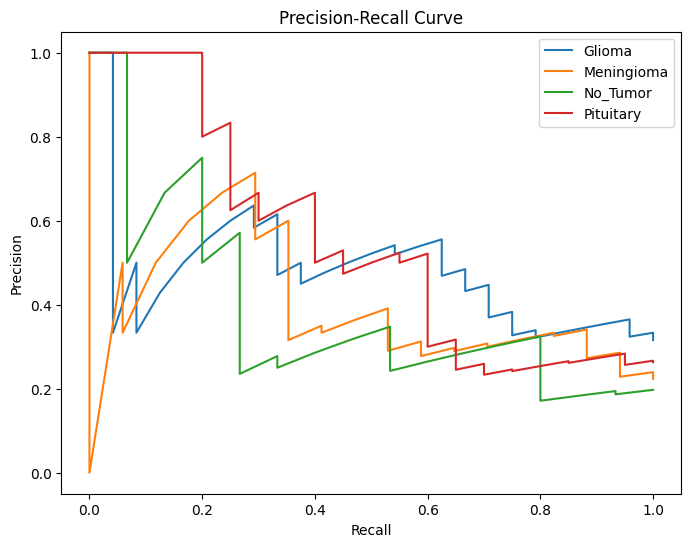


Training CustomCNN...
Epoch [1/10] Train Loss: 1.3721 Train Acc: 31.23% Val Loss: 1.3518 Val Acc: 31.58%
Epoch [2/10] Train Loss: 1.3418 Train Acc: 34.88% Val Loss: 1.3490 Val Acc: 32.89%
Epoch [3/10] Train Loss: 1.3000 Train Acc: 37.54% Val Loss: 1.3953 Val Acc: 32.89%
Epoch [4/10] Train Loss: 1.2806 Train Acc: 38.21% Val Loss: 1.3983 Val Acc: 30.26%
Epoch [5/10] Train Loss: 1.2700 Train Acc: 38.87% Val Loss: 1.4097 Val Acc: 31.58%
Epoch [6/10] Train Loss: 1.2541 Train Acc: 39.20% Val Loss: 1.4290 Val Acc: 39.47%
Epoch [7/10] Train Loss: 1.2475 Train Acc: 38.87% Val Loss: 1.4350 Val Acc: 38.16%
Epoch [8/10] Train Loss: 1.2493 Train Acc: 40.20% Val Loss: 1.4431 Val Acc: 34.21%
Epoch [9/10] Train Loss: 1.2352 Train Acc: 39.53% Val Loss: 1.4028 Val Acc: 32.89%
Epoch [10/10] Train Loss: 1.2418 Train Acc: 40.86% Val Loss: 1.4012 Val Acc: 31.58%

Evaluation Results:
Accuracy:  0.3158
Precision: 0.2459
Recall:    0.3158
F1-score:  0.2266


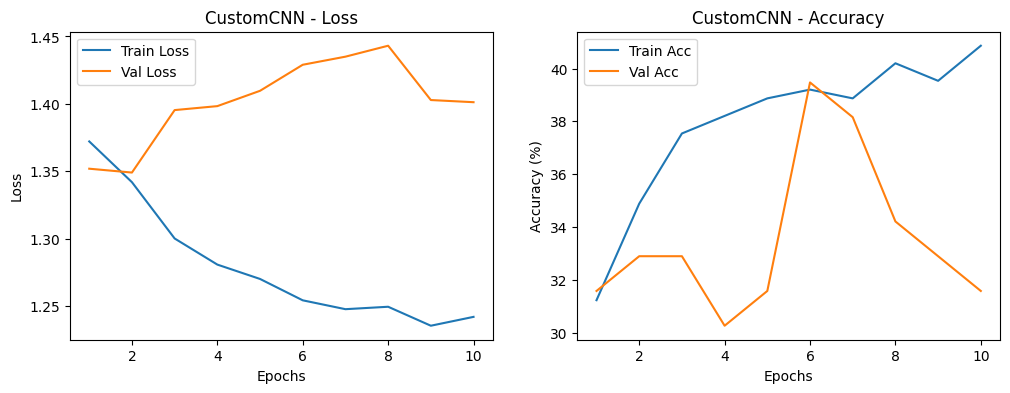

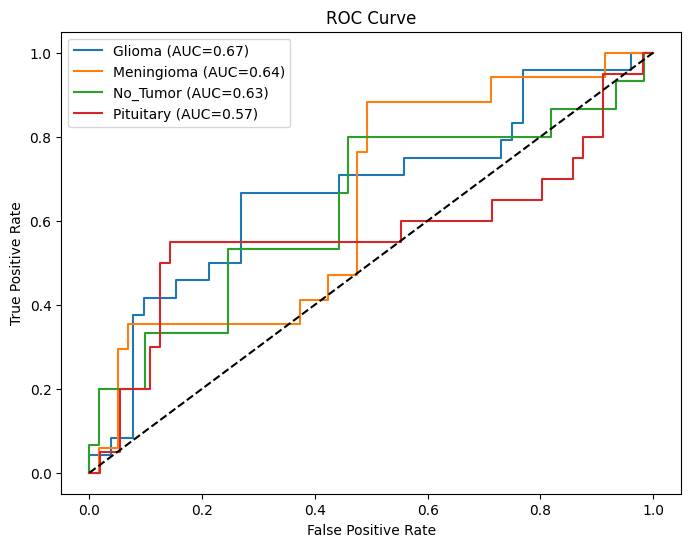

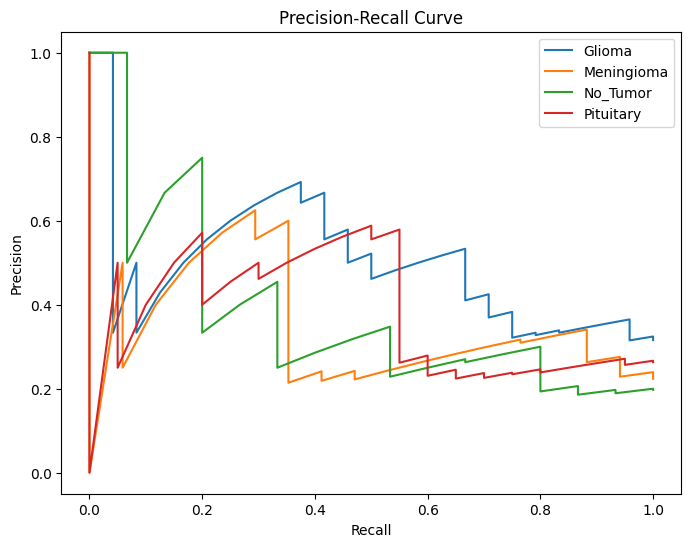

Done. Results saved to training_results.json


In [16]:
models = {
    'InceptionNet': InceptionNet(num_classes=len(class_names)),
    'ResNetSmall' : ResNetSmall(num_classes=len(class_names)),
    'DenseNetSmall': DenseNetSmall(num_classes=len(class_names)),
    'HybridNet': HybridNet(num_classes=len(class_names)),
    'CustomCNN': CustomCNN(num_classes=len(class_names)),
}

NUM_EPOCHS = 10
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        trained_model, curves = train_model(model, train_loader, test_loader, num_epochs=NUM_EPOCHS)
    except RuntimeError as e:
        print('RuntimeError during training (likely OOM). Try reducing BATCH_SIZE or IMG_SIZE.)')
        raise

    acc, prec, rec, f1 = evaluate_model(trained_model, test_loader, class_names)
    results[name] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'curves': curves}

    plot_training_curves(curves, name)
    plot_roc_pr_curves(trained_model, test_loader, class_names)

# Save results
import json
with open('training_results.json', 'w') as f:
    # curves is not JSON serializable; save only numeric metrics
    summary = {k: {kk: results[k][kk] for kk in ['accuracy', 'precision', 'recall', 'f1']} for k in results}
    json.dump(summary, f, indent=2)

print('Done. Results saved to training_results.json')

# Confession Matrics

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

def evaluate_model(model, test_loader, class_names, model_name="model"):
    model = model.to(device)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print('\nEvaluation Results:')
    print(f'Accuracy:  {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall:    {rec:.4f}')
    print(f'F1-score:  {f1:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))  # new figure for each model
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca(), colorbar=False)
    plt.title(f"Confusion Matrix - {model_name}")

    # Save confusion matrix
    os.makedirs("confusion_matrices", exist_ok=True)
    plt.savefig(f"confusion_matrices/confusion_matrix_{model_name}.png")
    plt.show()

    return acc, prec, rec, f1
